# **Алгоритм фильтрации спам-сообщений (Spam filter)**

## **Используемые библиотеки**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold, cross_val_score)

from sklearn.metrics import (recall_score, precision_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay,
                             precision_recall_curve)

from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB, ComplementNB

from scipy.sparse import csr_matrix, hstack

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
np.random.seed(17)

## **Работа с данными**

Данные состоят из более 5.500 записей, каждая из которых содержит **текст СМС-сообщения и метку**, является ли оно спамом.  
  
Ссылка на данные: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

### **Загрузка и очистка данных**

Прочитаем данные и очистим их от лишних колонок:

In [ ]:
data = pd.read_csv(r"C:\Users\User\Desktop\data\spam\spam.csv", encoding='latin-1')

In [ ]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
data['spam'] = [1 if x == 'spam' else 0 for x in data['v1']]

data.drop(columns=['v1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

data = data.rename(columns={'v2': 'message'})

In [ ]:
data

,message,spam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1
5568,Will Ì_ b going to esplanade fr home?,0
5569,"Pity, * was in mood for that. So...any other s...",0
5570,The guy did some bitching but I acted like i'd...,0


Поделим датасет на тренировочную и тестовую выборки:

In [ ]:
data_train, data_test = train_test_split(data, test_size=0.3, random_state=17)
data_train

,message,spam
3176,In meeting da. I will call you,0
3565,Its ok..come to my home it vl nice to meet and...,0
3981,His frens go then he in lor. Not alone wif my ...,0
1880,Just seeing your missed call my dear brother. ...,0
3905,Went fast asleep dear.take care.,0
...,...,...
1337,Then she buying today? ÌÏ no need to c meh...,0
406,All was well until slightly disastrous class t...,0
5510,I went to project centre,0
2191,Thankyou so much for the call. I appreciate yo...,0


Проанализируем тренировочную выборку:

### **Анализ данных**

Посмотрим на количество уникальных сообщений относительно метки, а также выведем самые частовстречающиеся сообщения:

In [ ]:
data_train.groupby('spam').describe().T

spam                                 0  \
message count                     3383   
        unique                    3219   
        top     Sorry, I'll call later   
        freq                        20   

spam                                                            1  
message count                                                 517  
        unique                                                476  
        top     HMV BONUS SPECIAL 500 pounds of genuine HMV vo...  
        freq                                                    3

Неудивительно, среди сообщений, **не являющихся спамом**, самым популярным является сообщение о намерении перезвонить позже.  
  
Среди **спам-сообщений** самое популярное сообщение повторяется лишь трижды, значит, в данной выборке отсутствуют крупные спам-рассылки, состоящие из одинаковых сообщений.  
  
В целом, среди обеих категорий СМС доминируют уникальные, неповторяющиеся сообщения.

Проанализируем распределения длин сообщений в целом и отдельно по классам:

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

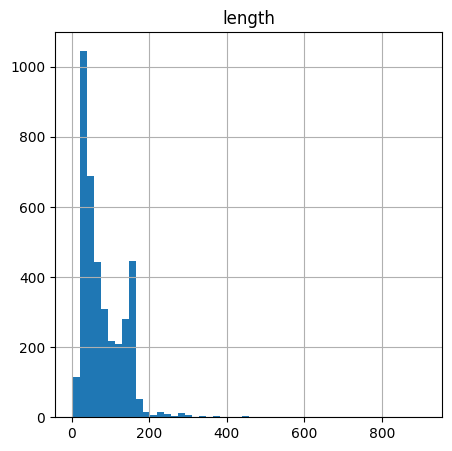

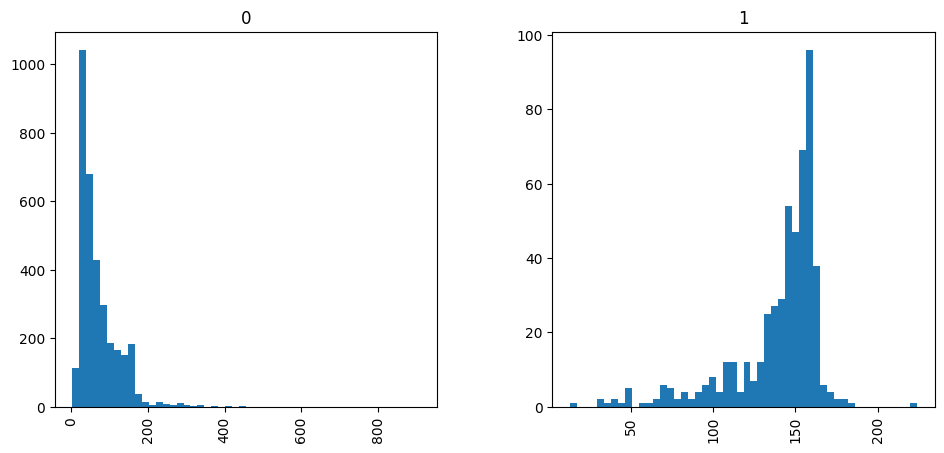

In [ ]:
data_train['length'] = data_train['message'].apply(len)
data_train.hist(column='length', bins=50, figsize=(5,5))
data_train.hist(column='length', by='spam', bins=50, figsize=(11,5))

На общем графике распределения длин сообщений можем увидеть **две явновыраженные моды**, возможно они относятся к соответствующим классам сообщений;  
  
Действительно, сообщения, не являющиеся спамом, в среднем намного короче, чем спам-сообщения. Значит, эти две моды относятся соответственно к **не спам** и **спам сообщениям**.
  
Вторая мода ниже первой, ведь спам-сообщений в несколько раз меньше обычных.

Рассмотрим то же распределение в виде boxplot-графика:

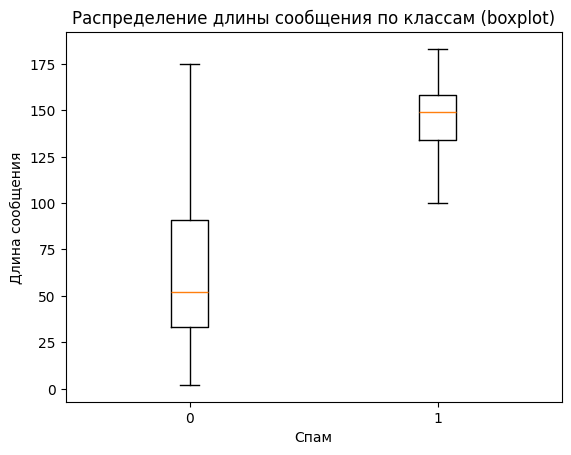

In [ ]:
plt.figure()
plt.boxplot([data_train[data_train.spam == 0].length, data_train[data_train.spam == 1].length],
            labels=["0", "1"], showfliers=False)
plt.xlabel("Спам")
plt.ylabel("Длина сообщения")
plt.title("Распределение длины сообщения по классам (boxplot)")
plt.show()

Оценим дисбаланс классов:

In [ ]:
data_train['spam'].value_counts()

spam
0    3383
1     517
Name: count, dtype: int64

### **Примеры сообщений**

Выведем по 10 случайных спам-сообщений и обычных СМС:

In [ ]:
spam_sample = data_train[data_train['spam'] == 1]['message'].sample(n=10, random_state=17)

print('Примеры спама: \n')

for obj in spam_sample:
    print(obj, '\n')

Примеры спама: 

PRIVATE! Your 2003 Account Statement for 07808247860 shows 800 un-redeemed S. I. M. points. Call 08719899229 Identifier Code: 40411 Expires 06/11/04 

As one of our registered subscribers u can enter the draw 4 a 100 G.B. gift voucher by replying with ENTER. To unsubscribe text STOP 

Congrats! 2 mobile 3G Videophones R yours. call 09063458130 now! videochat wid your mates, play java games, Dload polyPH music, noline rentl. 

SMS AUCTION You have won a Nokia 7250i. This is what you get when you win our FREE auction. To take part send Nokia to 86021 now. HG/Suite342/2Lands Row/W1JHL 16+ 

Text BANNEDUK to 89555 to see! cost 150p textoperator g696ga 18+ XXX 

Todays Vodafone numbers ending with 4882 are selected to a receive a å£350 award. If your number matches call 09064019014 to receive your å£350 award. 

Last chance 2 claim ur å£150 worth of discount vouchers-Text YES to 85023 now!SavaMob-member offers mobile T Cs 08717898035. å£3.00 Sub. 16 . Remove txt X or STOP 


In [ ]:
normal_sample = data_train[data_train['spam'] == 0]['message'].sample(n=10, random_state=17)

print('Примеры нормальных сообщений: \n')

for obj in normal_sample:
    print(obj, '\n')

Примеры нормальных сообщений: 

Long after I quit. I get on only like 5 minutes a day as it is. 

Waiting in e car 4 my mum lor. U leh? Reach home already? 

Ok thanx... 

K..then come wenever u lik to come and also tel vikky to come by getting free time..:-) 

Po de :-):):-):-):-). No need job aha. 

I uploaded mine to Facebook 

Lmao but its so fun... 

I thk 530 lor. But dunno can get tickets a not. Wat u doing now? 

No prob. I will send to your email. 

I love to cuddle! I want to hold you in my strong arms right now... 



Можем заметить, что **обычные сообщения действительно короче спам-сообщений**. Также в спам-сообщениях больше **цифр, специальных символов и символов в верхнем регистре**.

## **Итоговая обработка данных**

Получим объекты датасета и соответствующие метки:

In [ ]:
X = data['message']
y = data['spam']

Далее поделим датасет на **тренировочную и тестовую части**;  
  
Преобразуем **тексты сообщений в признаки**: в качестве признаков возьмем все уникальные наборы от 3 до 5 символов, исключив те, что встречаются более чем в 95% сообщений и менее чем в 1% сообщений. Значениями признаков являются их **TF-IDF** для данного сообщения;  
  
Зададим стратегию **кросс-валидации**:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    shuffle=True, stratify=y,
                                                    random_state=17)

vectorizer_tfidf = TfidfVectorizer(analyzer='char', ngram_range=(3, 5), max_df=0.95,
                                   min_df=0.01,
                                   sublinear_tf=True)

X_train_transformed = vectorizer_tfidf.fit_transform(X_train)
X_test_transformed = vectorizer_tfidf.transform(X_test)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

Проверим размеры тренировочной и тестовой выборок:

In [ ]:
print(f'Размеры тренировочной выборки: {X_train_transformed.shape}')
print(f'Размеры тестовой выборки: {X_test_transformed.shape}')

Размеры тренировочной выборки: (3900, 3708)
Размеры тестовой выборки: (1672, 3708)


## **Обучение моделей**

Обучим модели **логистической регрессии и наивного Байесовского классификатора**.  
  
В качестве целевой метрики возьмем **F1 score**.

### **Логистическая регрессия**

Инициализируем логистическую регрессию и получим ее качество на кросс-валидации. Затем подберем оптимальный параметр регуляризации и также получим качество оптимизированной модели:

In [ ]:
log_reg = LogisticRegression(class_weight='balanced', random_state=17)

log_reg_scores = cross_val_score(log_reg, X_train_transformed, y_train, cv=cv,
                                 scoring='f1')

print(f'Значения метрики для разных фолдов: {np.round(log_reg_scores, 3)}, \nСреднее значение метрики: {np.round(np.mean(log_reg_scores), 3)}')

Значения метрики для разных фолдов: [0.911 0.945 0.947 0.937 0.943], 
Среднее значение метрики: 0.937


In [ ]:
params_log_reg = {'C': np.logspace(-2, 3, 10)}
log_reg_cv = GridSearchCV(log_reg, param_grid=params_log_reg, cv=cv,
                        scoring='f1', verbose=3, n_jobs=8)

log_reg_cv.fit(X_train_transformed, y_train)
print(f'Лучший коэффициент регуляризации: {log_reg_cv.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучший коэффициент регуляризации: {'C': np.float64(21.544346900318846)}


In [ ]:
log_reg_cv = LogisticRegression(**log_reg_cv.best_params_,
                                class_weight='balanced', random_state=17)

log_reg_cv_scores = cross_val_score(log_reg_cv, X_train_transformed, y_train, cv=cv,
                                 scoring='f1')

print(f'Значения метрики для разных фолдов: {np.round(log_reg_cv_scores, 3)}, \nСреднее значение метрики: {np.round(np.mean(log_reg_cv_scores), 3)}')

Значения метрики для разных фолдов: [0.925 0.955 0.966 0.951 0.957], 
Среднее значение метрики: 0.951


Выведем матрицу ошибок, а также значения метрик Precision, Recall и F1 score:

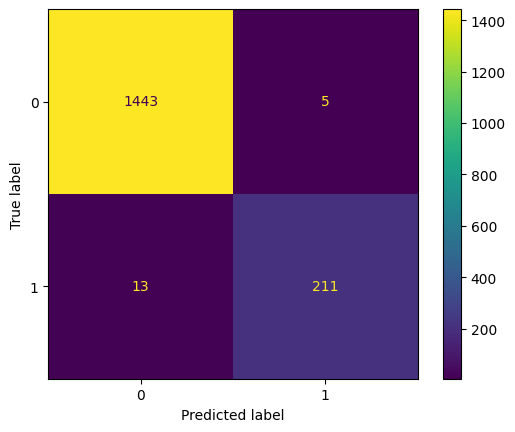

Precision: 0.977
Recall: 0.942
F1-score: 0.959


In [ ]:
log_reg_cv.fit(X_train_transformed, y_train)
log_reg_cv_pred =  log_reg_cv.predict(X_test_transformed)

cm_log_reg = confusion_matrix(y_test, log_reg_cv_pred, labels=log_reg_cv.classes_)
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg,
                              display_labels=log_reg_cv.classes_)
disp_log_reg.plot()
plt.grid(False)
plt.show()

print(f"Precision: {np.round(precision_score(y_test, log_reg_cv_pred), 3)}")
print(f"Recall: {np.round(recall_score(y_test, log_reg_cv_pred), 3)}")
print(f"F1-score: {np.round(f1_score(y_test, log_reg_cv_pred), 3)}")

Модель показала очень хорошее качество на тестовой выборке. Можно заметить большую склонность к пропускам, чем к ложно-положительным срабатываниям.   
  
Попробуем обучить модели НБК (Наивный Байесовский классификатор):

### **Наивный Байесовский классификатор**

В данном проекте будем использовать две реализации НБК в sklearn: **MultinomialNB и ComplementNB**. Оба хорошо подходят для работы с текстовыми данными, ведь признаки представляют собой счетчики слов (наборов символов), а распределение признаков в объекте - мультиномиальное.  
  
Также, исходя из этой логики, для НБК лучше использовать **CountVectorizer**, ведь в таком случае значения признаков - натуральные числа, показывающие сколько раз данная последовательность слов встретилась в этом сообщении.

Из получившихся признаков не будем удалять частовстречающиеся и редковстречающиеся, ведь с ними модели показывают лучшее качество:

In [ ]:
vectorizer_count = CountVectorizer(analyzer='char', ngram_range=(3, 5))

X_train_bayes = vectorizer_count.fit_transform(X_train)
X_test_bayes = vectorizer_count.transform(X_test)

Проверим размеры тренировочной и тестовой выборок:

In [ ]:
print(f'Размеры тренировочной выборки: {X_train_bayes.shape}')
print(f'Размеры тестовой выборки: {X_test_bayes.shape}')

Размеры тренировочной выборки: (3900, 125814)
Размеры тестовой выборки: (1672, 125814)


#### **MultinomialNB**

Проделаем с **MultinomialNB** действия, аналогичные логистической регрессии.  
  
Также сравним метрики, полученные с использованием **CountVectorizer и TfidfVectorizer**.

In [ ]:
multinomial_bayes = MultinomialNB()

mb_scores = cross_val_score(multinomial_bayes, X_train_bayes, y_train,
                            cv=cv, scoring='f1')

print('CountVectorizer')
print(f'Значения метрики для разных фолдов: {np.round(mb_scores, 3)}, \nСреднее значение метрики: {np.round(np.mean(mb_scores), 3)}')

CountVectorizer
Значения метрики для разных фолдов: [0.941 0.943 0.935 0.948 0.935], 
Среднее значение метрики: 0.94


In [ ]:
vectorizer_compare = TfidfVectorizer(analyzer='char', ngram_range=(3, 5))

X_train_compare = vectorizer_compare.fit_transform(X_train)
X_test_compare = vectorizer_compare.transform(X_test)

print(f'Размеры тренировочной выборки: {X_train_compare.shape}')
print(f'Размеры тестовой выборки: {X_test_compare.shape}', '\n')

mb_scores_tfidf = cross_val_score(multinomial_bayes, X_train_compare, y_train,
                            cv=cv, scoring='f1')

print('TfidfVectorizer со всеми признаками')
print(f'Значения метрики для разных фолдов: {np.round(mb_scores_tfidf, 3)}, \nСреднее значение метрики: {np.round(np.mean(mb_scores_tfidf), 3)}')

mb_scores_tfidf = cross_val_score(multinomial_bayes, X_train_transformed, y_train,
                            cv=cv, scoring='f1')

print('TfidfVectorizer без частых и редких признаков')
print(f'Значения метрики для разных фолдов: {np.round(mb_scores_tfidf, 3)}, \nСреднее значение метрики: {np.round(np.mean(mb_scores_tfidf), 3)}')

Размеры тренировочной выборки: (3900, 125814)
Размеры тестовой выборки: (1672, 125814) 

TfidfVectorizer со всеми признаками
Значения метрики для разных фолдов: [0.545 0.595 0.609 0.6   0.542], 
Среднее значение метрики: 0.578


Действительно, **CountVectorizer** лучше всего подходит для НБК.

Подберем лучшие гиперпараметры для данной модели, получим значения метрик и построим матрицу ошибок:

In [ ]:
params_mb = {'alpha': np.logspace(-10, 2, 30),
                  'fit_prior': [True, False]}

mb_cv = GridSearchCV(multinomial_bayes, param_grid=params_mb, cv=cv, scoring='f1',
                     verbose=3, n_jobs=8)

mb_cv.fit(X_train_bayes, y_train)
print(f'Лучшие значения гиперпараметров: {mb_cv.best_params_}')

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Лучшие значения гиперпараметров: {'alpha': np.float64(0.001082636733874054), 'fit_prior': True}


In [ ]:
mb_cv =  MultinomialNB(**mb_cv.best_params_)

mb_cv_scores = cross_val_score(mb_cv, X_train_bayes, y_train, cv=cv,
                                 scoring='f1')

print(f'Значения метрики для разных фолдов: {np.round(mb_cv_scores, 3)}, \nСреднее значение метрики: {np.round(np.mean(mb_cv_scores), 3)}')

Значения метрики для разных фолдов: [0.94  0.956 0.961 0.957 0.941], 
Среднее значение метрики: 0.951


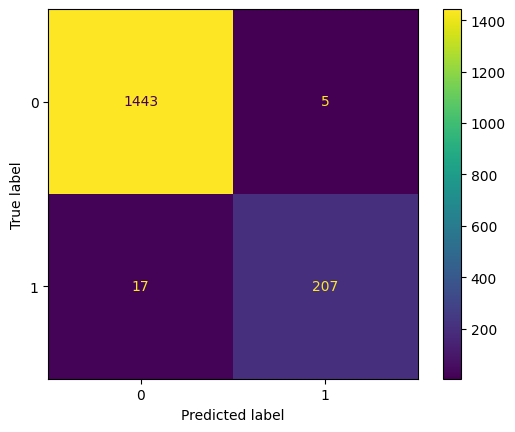

Precision: 0.976
Recall: 0.924
F1-score: 0.95


In [ ]:
mb_cv.fit(X_train_bayes, y_train)
mb_cv_pred =  mb_cv.predict(X_test_bayes)

cm_mb = confusion_matrix(y_test, mb_cv_pred, labels=mb_cv.classes_)
disp_mb = ConfusionMatrixDisplay(confusion_matrix=cm_mb,
                              display_labels=mb_cv.classes_)
disp_mb.plot()
plt.grid(False)
plt.show()

print(f"Precision: {np.round(precision_score(y_test, mb_cv_pred), 3)}")
print(f"Recall: {np.round(recall_score(y_test, mb_cv_pred), 3)}")
print(f"F1-score: {np.round(f1_score(y_test, mb_cv_pred), 3)}")

Наивный Байесовский классификатор, основанный на мультиномиальном распределении, справился с задачей **хуже** логистической регрессии, пропустив на 4 объекта больше.  
  
Обучим другую реализацию НБК:

#### **ComplementNB**

**ComplementNB** также основан на мультиномиальном распределении, но предназначен для задач с дисбалансом классов.

Обучим данную модель и получим результаты аналогично предыдущему НБК:

In [ ]:
complement_bayes = ComplementNB()

cb_scores = cross_val_score(complement_bayes, X_train_bayes, y_train,
                            cv=cv, scoring='f1')

print('CountVectorizer')
print(f'Значения метрики для разных фолдов: {np.round(cb_scores, 3)}, \nСреднее значение метрики: {np.round(np.mean(cb_scores), 3)}')

CountVectorizer
Значения метрики для разных фолдов: [0.936 0.934 0.93  0.944 0.93 ], 
Среднее значение метрики: 0.935


In [ ]:
cb_scores_tfidf = cross_val_score(complement_bayes, X_train_compare, y_train,
                            cv=cv, scoring='f1')

print('TfidfVectorizer со всеми признаками')
print(f'Значения метрики для разных фолдов: {np.round(cb_scores_tfidf, 3)}, \nСреднее значение метрики: {np.round(np.mean(cb_scores_tfidf), 3)} \n')

cb_scores_tfidf = cross_val_score(complement_bayes, X_train_transformed, y_train,
                            cv=cv, scoring='f1')

print('TfidfVectorizer без частых и редких признаков')
print(f'Значения метрики для разных фолдов: {np.round(cb_scores_tfidf, 3)}, \nСреднее значение метрики: {np.round(np.mean(cb_scores_tfidf), 3)}')

TfidfVectorizer со всеми признаками
Значения метрики для разных фолдов: [0.716 0.743 0.824 0.782 0.75 ], 
Среднее значение метрики: 0.763 

TfidfVectorizer без частых и редких признаков
Значения метрики для разных фолдов: [0.798 0.825 0.856 0.824 0.877], 
Среднее значение метрики: 0.836


И в случае с данной моделью **CountVectorizer** показал себя лучше.

In [ ]:
params_cb = {'alpha': np.logspace(-10, 2, 30),
                  'fit_prior': [True, False]}

cb_cv = GridSearchCV(complement_bayes, param_grid=params_cb, cv=cv,
                     scoring='f1', verbose=3, n_jobs=8)

cb_cv.fit(X_train_bayes, y_train)
print(f'Лучшие значения гиперпараметров: {cb_cv.best_params_}')

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Лучшие значения гиперпараметров: {'alpha': np.float64(0.001082636733874054), 'fit_prior': True}


In [ ]:
cb_cv =  ComplementNB(**cb_cv.best_params_)

cb_cv_scores = cross_val_score(cb_cv, X_train_bayes, y_train, cv=cv,
                                 scoring='f1')

print(f'Значения метрики для разных фолдов: {np.round(cb_cv_scores, 3)}, \nСреднее значение метрики: {np.round(np.mean(cb_cv_scores), 3)}')

Значения метрики для разных фолдов: [0.94  0.951 0.961 0.957 0.941], 
Среднее значение метрики: 0.95


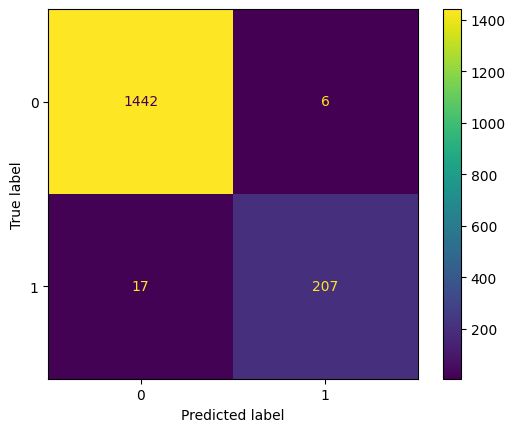

Precision: 0.972
Recall: 0.924
F1-score: 0.947


In [ ]:
cb_cv.fit(X_train_bayes, y_train)
cb_cv_pred = cb_cv.predict(X_test_bayes)

cm_cb = confusion_matrix(y_test, cb_cv_pred, labels=cb_cv.classes_)
disp_cb = ConfusionMatrixDisplay(confusion_matrix=cm_cb,
                              display_labels=cb_cv.classes_)
disp_cb.plot()
plt.grid(False)
plt.show()

print(f"Precision: {np.round(precision_score(y_test, cb_cv_pred), 3)}")
print(f"Recall: {np.round(recall_score(y_test, cb_cv_pred), 3)}")
print(f"F1-score: {np.round(f1_score(y_test, cb_cv_pred), 3)}")

Этот классификатор оказался чуть хуже предыдущего, ведь количество ложно-положительных ответов увеличилось на 1.

В итоге лучшей моделью оказалась **логистическая регрессия**. Попробуем еще улучшить ее результат:

### **Улучшение логистической регрессии**

Добавим в нашу выборку признак **length**, показывающий длину сообщения. Как мы выяснили в начале при анализе данных, спам-сообщения сильно длиннее обычных.

Данный признак **прологарифмируем и стандартизируем**, уменьшив этим влияние выбросов и приведя его значения в окрестность нуля:

In [ ]:
len_train = np.array([len(text) for text in X_train]).reshape(-1, 1)
len_test = np.array([len(text) for text in X_test]).reshape(-1, 1)

len_train = np.log1p(len_train)
len_test = np.log1p(len_test)

scaler = StandardScaler()
len_train_scaled = scaler.fit_transform(len_train)
len_test_scaled = scaler.transform(len_test)

len_train_csr = csr_matrix(len_train_scaled)
len_test_csr = csr_matrix(len_test_scaled)

X_train_transformed_len = hstack([X_train_transformed, len_train_csr])
X_test_transformed_len = hstack([X_test_transformed, len_test_csr])

Получим качество **логистической регрессии** на дополненных данных с помощью кросс-валидации:

In [ ]:
log_reg_len = LogisticRegression(class_weight='balanced', random_state=17)

log_reg_len_scores = cross_val_score(log_reg_len, X_train_transformed_len,
                                     y_train, cv=cv, scoring='f1')

print(f'Значения метрики для разных фолдов: {np.round(log_reg_len_scores, 3)}, \nСреднее значение метрики: {np.round(np.mean(log_reg_len_scores), 3)}')

Значения метрики для разных фолдов: [0.913 0.928 0.931 0.938 0.917], 
Среднее значение метрики: 0.926


Подберем коэффициент регуляризации и аналогично получим значение метрики регуляризованной модели:

In [ ]:
log_reg_len_cv = GridSearchCV(log_reg_len, param_grid=params_log_reg, cv=cv,
                        scoring='f1', verbose=3, n_jobs=8)

log_reg_len_cv.fit(X_train_transformed_len, y_train)
print(f'Лучший коэффициент регуляризации: {log_reg_len_cv.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучший коэффициент регуляризации: {'C': np.float64(77.42636826811278)}


Заметим, что с добавлением признака **значение оптимального коэффициента регуляризации увеличилось почти в 4 раза** (регуляризация ослабляется с увеличением коэффициента регуляризации C). Возможно, признак длины сообщения несет в себе много информации и модель, ослабляя регуляризацию, стремится максимально его использовать.

In [ ]:
log_reg_len_cv = LogisticRegression(**log_reg_len_cv.best_params_,
                                    class_weight='balanced', random_state=17)

log_reg_len_cv_scores = cross_val_score(log_reg_len_cv, X_train_transformed_len,
                                        y_train, cv=cv, scoring='f1')

print(f'Значения метрики для разных фолдов: {np.round(log_reg_len_cv_scores, 3)}, \nСреднее значение метрики: {np.round(np.mean(log_reg_len_cv_scores), 3)}')

Значения метрики для разных фолдов: [0.93  0.97  0.966 0.956 0.952], 
Среднее значение метрики: 0.955


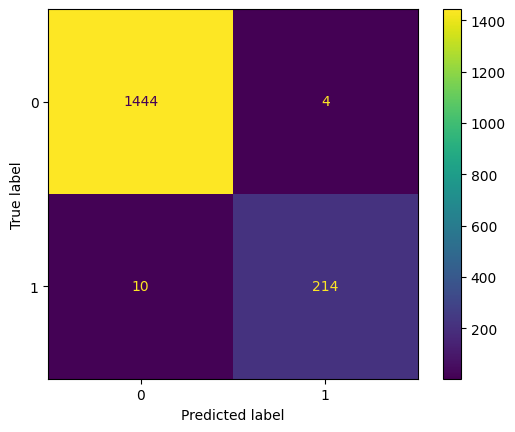

Precision: 0.982
Recall: 0.955
F1-score: 0.968


In [ ]:
log_reg_len_cv.fit(X_train_transformed_len, y_train)
log_reg_len_cv_pred = log_reg_len_cv.predict(X_test_transformed_len)

cm_log_reg_len = confusion_matrix(y_test, log_reg_len_cv_pred,
                              labels=log_reg_len_cv.classes_)
disp_log_reg_len = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg_len,
                              display_labels=log_reg_len_cv.classes_)
disp_log_reg_len.plot()
plt.grid(False)
plt.show()

print(f"Precision: {np.round(precision_score(y_test, log_reg_len_cv_pred), 3)}")
print(f"Recall: {np.round(recall_score(y_test, log_reg_len_cv_pred), 3)}")
print(f"F1-score: {np.round(f1_score(y_test, log_reg_len_cv_pred), 3)}")

Модель логистической регрессии с новым признаком показала **значительное увеличение** целевой метрики. Построим PR-curve и подберем порог классификации:

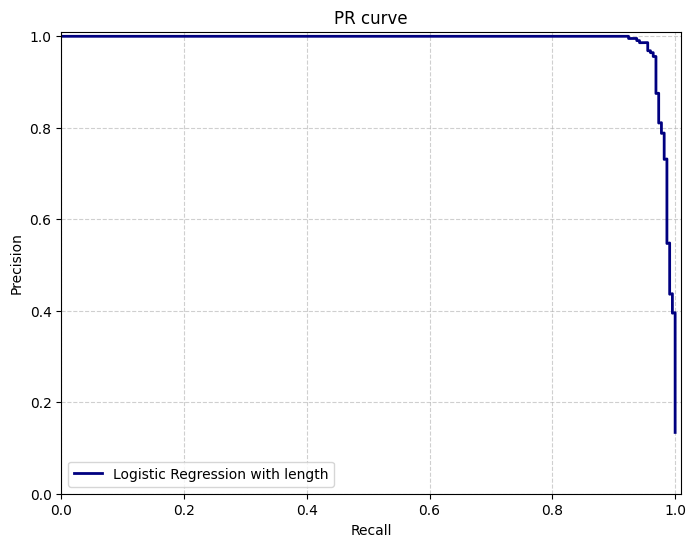

In [ ]:
log_reg_len_cv_proba = log_reg_len_cv.predict_proba(X_test_transformed_len)[:, 1]

prec_log_reg, rec_log_reg, thresh_log_reg = precision_recall_curve(y_test, log_reg_len_cv_proba)

plt.figure(figsize=(8, 6))
plt.plot(rec_log_reg, prec_log_reg, color='navy', lw=2, label='Logistic Regression with length')

plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc="lower left")
plt.show()

Для нашей задачи важно допускать **минимум ложно-положительных срабатываний**, чтобы важные и содержательные сообщения не отсеивались в корзину со спамом.  
  
Тогда зададим в качестве условия **метрику Precision, равную 0.99**, и подберем порог классификации, удовлетворяющий этому условию и дающий лучший **Recall**:

In [ ]:
target_precision = 0.99

target_idx = np.where(prec_log_reg[:-1] >= target_precision)[0][0]

print(f'Значение порога классификации: {thresh_log_reg[target_idx]}')
print(f'Значения precision и recall: {np.round(prec_log_reg[target_idx], 3)}, {np.round(rec_log_reg[target_idx], 3)}')

Значение порога классификации: 0.7391646639133297
Значения precision и recall: 0.991, 0.942


## **Интерпретация результатов**

### **Признаки**

Выведем признаки итоговой модели с наибольшими и наименьшими значениями соответствующих весов:

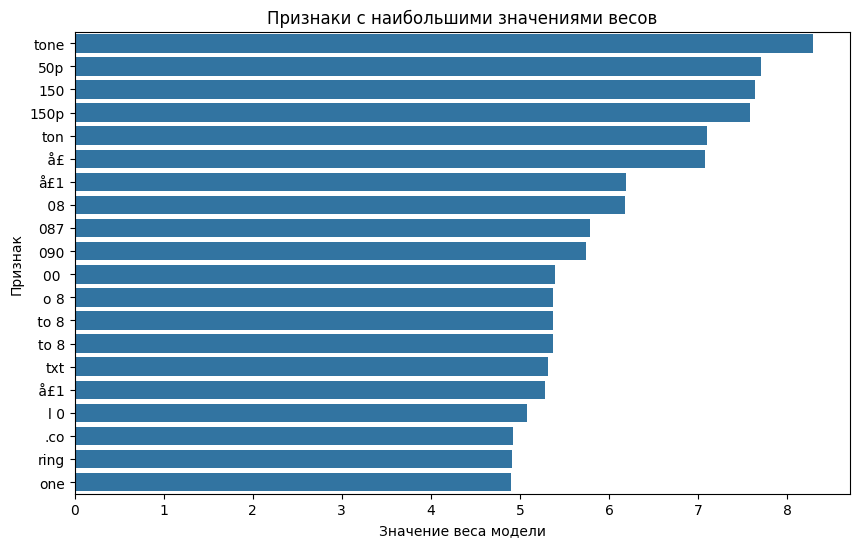

Значение веса при признаке "Длина": 2.914


In [ ]:
coefs = log_reg_len_cv.coef_[0]
feature_names = vectorizer_tfidf.get_feature_names_out()
spam_idx = np.argsort(coefs)[-20:][::-1]

feature_importance_spam = pd.DataFrame({'Feature': feature_names[spam_idx],
                                        'Importance': coefs[spam_idx]})

feature_importance_spam = feature_importance_spam.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_spam)
plt.title('Признаки с наибольшими значениями весов')
plt.xlabel('Значение веса модели')
plt.ylabel('Признак')
plt.show()

print(f'Значение веса при признаке "Длина": {np.round(coefs[-1], 3)}')

Среди признаков, имеющих **наибольший вес**, много комбинаций из **чисел**, **символ £**, обозначающий фунт стерлингов, а также набор символов **.co**, что, вероятно, является частью какой-либо ссылки (.com).  
  
Стоит отметить, что вес добавленного **признака длины сообщения** тоже имеет большое значение;

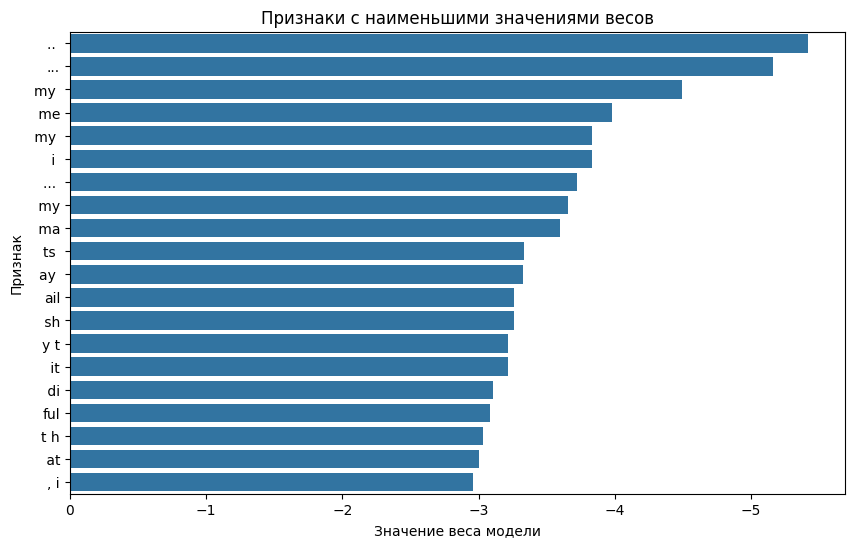

In [ ]:
not_spam_idx = np.argsort(coefs)[:20]

feature_importance_spam = pd.DataFrame({'Feature': feature_names[not_spam_idx],
                                        'Importance': coefs[not_spam_idx]})
feature_importance_spam = feature_importance_spam.sort_values(by='Importance', ascending=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_spam)
plt.gca().invert_xaxis()
plt.title('Признаки с наименьшими значениями весов')
plt.xlabel('Значение веса модели')
plt.ylabel('Признак')
plt.show()

Признаки с **наименьшим значением весов** представляют собой разные варианты **многоточий**, **личных местоимений** и различных комбинаций обычных букв.

### **Ошибки**

Создадим датафреймы, содержащие ошибки моделей, и выведем **ошибки первого рода** каждой модели.  
  
Начнем с логистической регрессии:

In [ ]:
df_errors_log_reg = pd.DataFrame({'message': X_test, 'true_label': y_test,
                                  'pred_label': log_reg_len_cv_pred})

fp_errors_log_reg = df_errors_log_reg[(df_errors_log_reg['true_label'] == 0) & (df_errors_log_reg['pred_label'] == 1)]
fn_errors_log_reg = df_errors_log_reg[(df_errors_log_reg['true_label'] == 1) & (df_errors_log_reg['pred_label'] == 0)]

for msg in fp_errors_log_reg['message']:
    print(msg, '\n')

They have a thread on the wishlist section of the forums where ppl post nitro requests. Start from the last page and collect from the bottom up. 

Camera quite good, 10.1mega pixels, 3optical and 5digital dooms. Have a lovely holiday, be safe and i hope you hav a good journey! Happy new year to you both! See you in a couple of weeks!  

Now that you have started dont stop. Just pray for more good ideas and anything i see that can help you guys i.ll forward you a link. 

We are pleased to inform that your application for Airtel Broadband is processed successfully. Your installation will happen within 3 days. 



Среди сообщений, которые логистическая регрессия **ошибочно посчитала спамом**, **длинные тексты**, состоящие из нескольких предложений. Второе по счету также содержит **много цифр** (характеристики камеры).

Посмотрим на ложно-положительные ошибки моделей НБК:

In [ ]:
df_errors_mb = pd.DataFrame({'message': X_test, 'true_label': y_test,
                          'pred_label': mb_cv_pred})

fp_errors_mb = df_errors_mb[(df_errors_mb['true_label'] == 0) & (df_errors_mb['pred_label'] == 1)]
fn_errors_mb = df_errors_mb[(df_errors_mb['true_label'] == 1) & (df_errors_mb['pred_label'] == 0)]

for msg in fp_errors_mb['message']:
    print(msg, '\n')

Yeah get the unlimited 

645 

I liked the new mobile 

Nokia phone is lovly.. 

Are you available for soiree on June 3rd? 



In [ ]:
df_errors_сb = pd.DataFrame({'message': X_test, 'true_label': y_test,
                          'pred_label': cb_cv_pred})

fp_errors_сb = df_errors_сb[(df_errors_сb['true_label'] == 0) & (df_errors_сb['pred_label'] == 1)]
fn_errors_сb = df_errors_сb[(df_errors_сb['true_label'] == 1) & (df_errors_сb['pred_label'] == 0)]

for msg in fp_errors_сb['message']:
    print(msg, '\n')

Yeah get the unlimited 

645 

I liked the new mobile 

U 2. 

Nokia phone is lovly.. 

Are you available for soiree on June 3rd? 



Выведем пересечения в ошибках двух Наивных Байесовских классификаторов:

In [ ]:
bayes_fp_intersection = pd.merge(fp_errors_сb, fp_errors_mb, on='message', how='inner')

for msg in bayes_fp_intersection['message']:
    print(msg, '\n')

Yeah get the unlimited 

645 

I liked the new mobile 

Nokia phone is lovly.. 

Are you available for soiree on June 3rd? 



Ожидаемо, **обе модели НБК допустили одинаковые ошибки первого рода**, за исключением того, что у ComplementNB на одну ошибку больше. Все эти сообщения достаточно **короткие**, некоторые содержат **цифры**.

Так как у всех моделей пропусков было больше, выведем только **пересечения ошибок второго рода всех трех моделей** и **двух моделей НБК**:

In [ ]:
fn_intersection_bayes = pd.merge(fn_errors_сb, fn_errors_mb, on='message', how='inner')
fn_intersection_full = pd.merge(fn_intersection_bayes, fn_errors_log_reg, on='message', how='inner')

for msg in fn_intersection_full['message']:
    print(msg, '\n')

Missed call alert. These numbers called but left no message. 07008009200 

How come it takes so little time for a child who is afraid of the dark to become a teenager who wants to stay out all night? 

Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net 

Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos? 

SMS. ac sun0819 posts HELLO:\You seem cool 

0A$NETWORKS allow companies to bill for SMS, so they are responsible for their \suppliers\" 

Hi ya babe x u 4goten bout me?' scammers getting smart..Though this is a regular vodafone no, if you respond you get further prem rate msg/subscription. Other nos used also. Beware! 



Некоторые из этих сообщений выглядят как обычные абстрактные мысли, вырванные из контекста, неудивительно, что все модели их пропустили. Остальные же содержат в себе **цифры** (в том числе, вероятно, номера телефонов), **ссылки, специальные символы**.

In [ ]:
for msg in fn_intersection_bayes['message']:
    print(msg, '\n')

print(f'\nКоличество ошибок, общих для НБК: {fn_intersection_bayes.shape[0]}')

Burger King - Wanna play footy at a top stadium? Get 2 Burger King before 1st Sept and go Large or Super with Coca-Cola and walk out a winner 

Missed call alert. These numbers called but left no message. 07008009200 

Free msg. Sorry, a service you ordered from 81303 could not be delivered as you do not have sufficient credit. Please top up to receive the service. 

Sorry! U can not unsubscribe yet. THE MOB offer package has a min term of 54 weeks> pls resubmit request after expiry. Reply THEMOB HELP 4 more info 

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv 

LookAtMe!: Thanks for your purchase of a video clip from LookAtMe!, you've been charged 35p. Think you can do better? Why not send a video in a MMSto 32323. 

This msg is for your mobile content order It has been resent as previous attempt failed due to network error Queries to customersqueries@netvision.uk.com 

How come it t

Пропуски Наивных Байесовских классификаторов **абсолютно совпадают** (у каждой модели по 17 пропусков и столько же в пересечении).

## **Дальнейшие действия**

1). Добавление **новых признаков для логистической регрессии** (отношений цифр, специальных символов, букв верхнего регистра к общей длине сообщения). Каждый признак необходимо оценить независимо друг от друга, оставить в итоговой модели только в случае, если данный признак **статистически значимо увеличивает ее качество**;  
  
2). Использование более **продвинутых NLP моделей и архитектур**, например, реккурентные нейросети или трансформеры;  
  
3). Объединение моделей НБК и логистической регрессии в **ансамбль** (использовать предсказания НБК в качестве признака для регрессии).